# Training Model PEPS
The notebook below shows the variational circuit training process. We implement a tensor neural network in PEPS architecture.

<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Training](#3)
4. [Accuracy](#4)

Parameters:
* corpping - `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`
* image size to resize - `(64, 64)`
* PCA components - `256`
* Split data to train and validation - `train_ratio=0.8`
* cost functino - cross entropy 

Output:
* Testing accuracy: 43.33%

<a id="1"></a> <br>
### Data Preparation

Initialize the ImageLoader to load and preprocess data.
Below, we load up to 100 images per label, applies cropping with specified parameters to focus on relevant image regions, and resizes each image to 64x64 pixels for consistency.

Cropping parameters: `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`.
Image size to resize: `(64, 64)`

In [2]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(['./Data_Sources/al5083/train'], ['./Data_Sources/al5083/train/train.json'], (64, 64))
all_data = loader.load_images(image_limit=100,vertical_start_split=0.3, vertical_end_split=1.0,
                              horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 600, Current label: 5, Total per label: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}

Total images loaded : 600


Shuffles the dataset and separates it into flattened features and labels.

In [2]:
import Modules.Utils
# Shuffles the dataset and separates it into flattened features and labels.
X_set,Y_set = Modules.Utils.prepare_data(all_data)

In [3]:
X_set[0].shape

(4096,)

Applies PCA to reduce the dimensionality of the given dataset to components = `256`

In [4]:
X_reduced = Modules.Utils.apply_pca(X_set, n_components=256)

Split train data to train set and validation set. `train_ratio=0.8`

In [5]:
X_train, Y_train, X_val, Y_val = Modules.Utils.split_data(X_reduced, Y_set, train_ratio=0.8)

Training set:

In [6]:
import numpy as np
values, counts = np.unique(Y_train, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[76 83 78 78 79 86]


Validation set:

In [7]:
import numpy as np
values, counts = np.unique(Y_val, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[24 17 22 22 21 14]


<a id="2"></a> <br>
### Model

(<Figure size 1800x900 with 1 Axes>, <Axes: >)

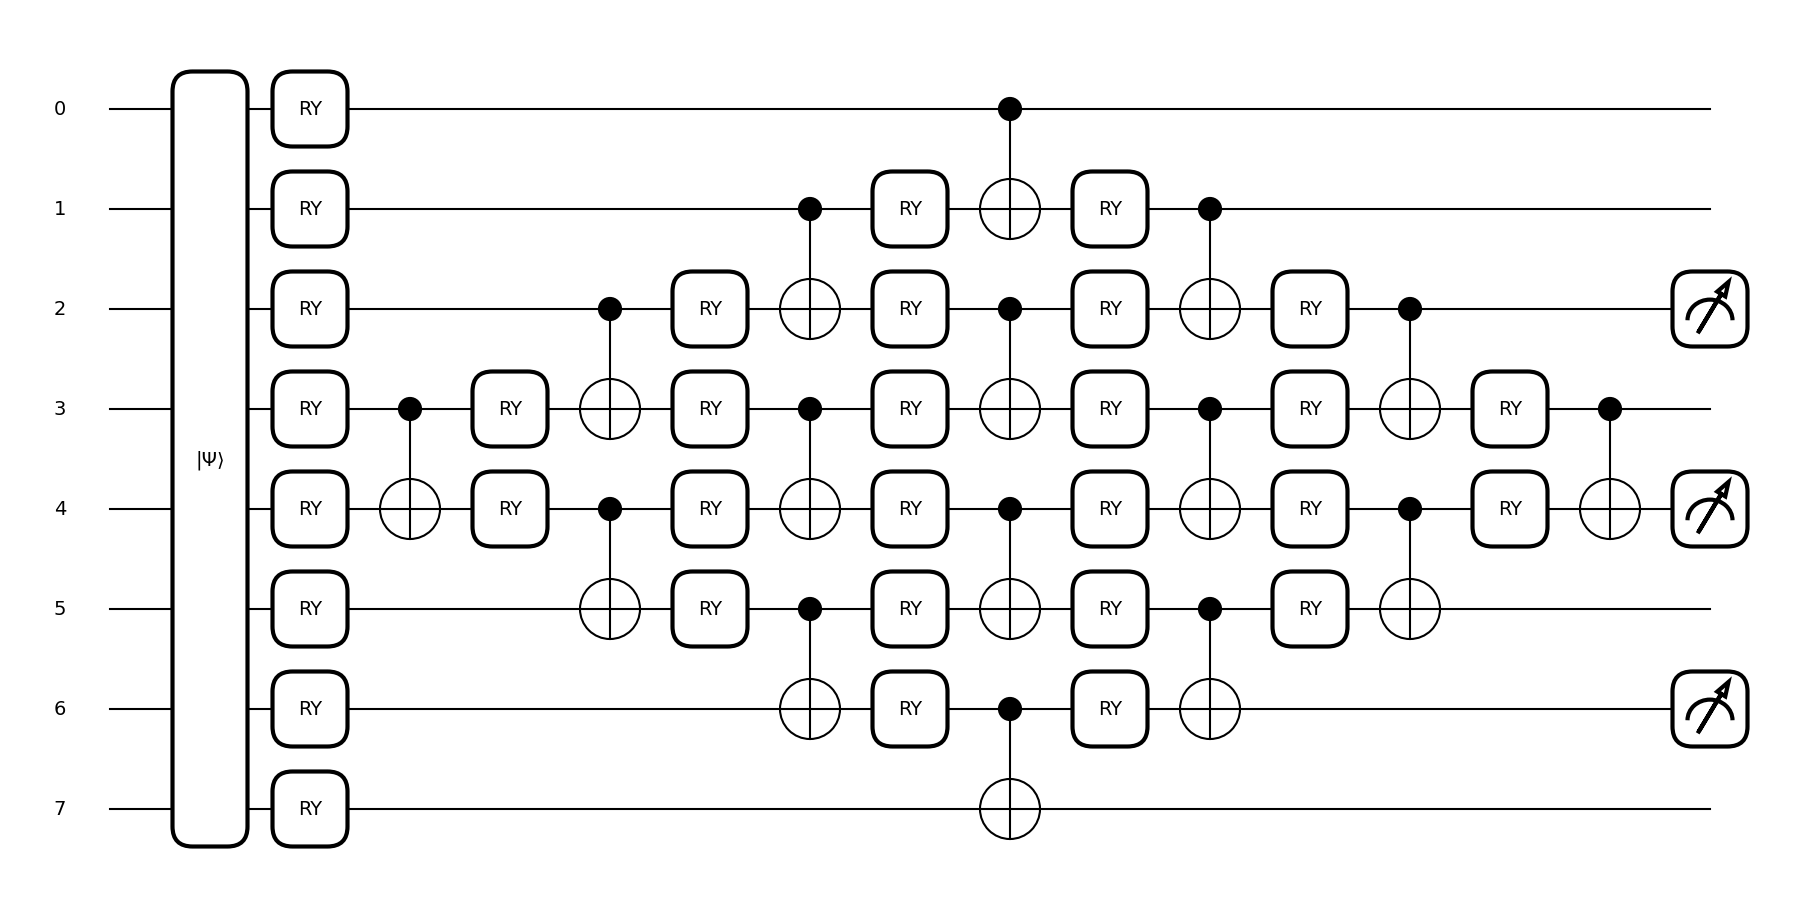

In [8]:
import pennylane as qml
from pennylane import numpy as np
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)
def circuit_peps(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    # qml.probs(wires =[1,3,5]) [3,5,7]
    return qml.probs(wires = [2,4,6])
    # return qml.probs(wires =[1,3,5])

weights = np.random.random(size=[32, 1])
qml.draw_mpl(circuit_peps, expansion_strategy="device")(X_train[0], weights)
#circuit_peps(X_train[0], weights)

<a id="3"></a> <br>
### Training

In [9]:
def costfunc(params):
    cost = 0
    y_true = [np.array([1, 0, 0, 0, 0, 0, 0, 0]), np.array([0, 1, 0, 0, 0, 0, 0, 0]), np.array([0, 0, 1, 0, 0, 0, 0, 0]), np.array([0, 0, 0, 1, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0, 0]), np.array([0, 0, 0, 0, 0, 1, 0, 0])]

    len_X_train = len(X_train)
    for i in range(len_X_train):
        prob = circuit_peps(X_train[i], params)

        if Y_train[i] == 0:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 1:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 2:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 3:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 4:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[4].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 5:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[5].astype(float)*np.log(prob.astype(float))))
    return cost

In [11]:
# training the circuit parameters
x2 = np.random.random(size=[32, 1], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.1)

for k in range(60):
    params,cost = optimizer.step_and_cost(costfunc, params)
    print(f"Step {k}, cost: {cost}")
print(params)

Step 0, cost: 2.073778298300435
Step 1, cost: 1.9506955032894873
Step 2, cost: 1.8541794984677185
Step 3, cost: 1.7782980979896352
Step 4, cost: 1.7414920440369004
Step 5, cost: 1.7118189225580738
Step 6, cost: 1.6818249841715018
Step 7, cost: 1.6615159044152867
Step 8, cost: 1.655032491770896
Step 9, cost: 1.6471475841933723
Step 10, cost: 1.6320821779445114
Step 11, cost: 1.6158359589843918
Step 12, cost: 1.6021997259557217
Step 13, cost: 1.5895372365266778
Step 14, cost: 1.5764496931559342
Step 15, cost: 1.5661921005956698
Step 16, cost: 1.5613844644022845
Step 17, cost: 1.5589782129169532
Step 18, cost: 1.5548143482093328
Step 19, cost: 1.5491066931617388
Step 20, cost: 1.5448048852545073
Step 21, cost: 1.5415504294756206
Step 22, cost: 1.5355554754380567
Step 23, cost: 1.5259123628844102
Step 24, cost: 1.5167828392054412
Step 25, cost: 1.5120379501140875
Step 26, cost: 1.5101860369274576
Step 27, cost: 1.5076286237418195
Step 28, cost: 1.5033582662161549
Step 29, cost: 1.498658015

### Checking the circuit on first X_val data.

In [12]:
x = circuit_peps(X_val[0], params)
np.argmax(x)

4

In [13]:
Y_val[0]

0

<a id="4"></a> <br>
### Calculating accuracy


In [14]:
test_correct = 0

for img, true_label in zip(X_val, Y_val):
    # Get predictions from the quantum circuit
    predictions = circuit_peps(img, params)

    # Determine the predicted label
    predicted_label = np.argmax(predictions)

    # Increment correct count if prediction matches the true label
    if predicted_label == true_label:
        test_correct += 1

# Calculate and print the testing accuracy percentage
accuracy = 100 * test_correct / len(Y_val)
print(f"Testing accuracy: {accuracy:.2f}%")

Testing accuracy: 43.33%
